In [1]:
import gym
import gym_kraby
import math as maths
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy as DC


# Simulation

In [2]:
class hexapod:
    def __init__(self):
        self.env= gym.make('gym_kraby:HexapodBulletEnv-v0', render=True)
        obs=self.env.reset()
        self.action_space=self.env.action_space.sample()  # take a random action
        self.sensors={"foot_0":4,"endcap_0":5,"foot_1":10,"endcap_1":11,
            "foot_2":16,"endcap_2": 17,"foot_3": 22,"endcap_3": 23,
            "foot_4": 28,"endcap_4": 29,"foot_5": 34,"endcap_5":35}
    def list_feet(self):
        _link_name_to_index = {self.env.p.getBodyInfo(self.env.robot_id)[0].decode('UTF-8'):-1,}
        for _id in range(self.env.p.getNumJoints(self.env.robot_id)):
            _name = self.env.p.getJointInfo(self.env.robot_id, _id)[12].decode('UTF-8')
            _link_name_to_index[_name] = _id
            if "endcap" in _name or "foot" in _name:
                print(_name,_id)
    def reset(self):
        obs=self.env.reset()
    def step(self,a):
        """
        step through environment with action a
        return reward and the force on the feet that are contacted numbered 0-5 for each leg
        """
        observation, reward, done, _ = self.env.step(a)  # step
        filtered=self.getContact()
        return reward,filtered 
    def getContact(self):
        VALS=np.array([[5,4],[11,10],[17,16],[23,22],[29,28],[35,34]])
        contact=self.env.p.getContactPoints(bodyA=self.env.robot_id)
        a_=np.array([[5,0],[11,0],[17,0],[23,0],[29,0],[35,0]])
        for c in contact:
            p=c[3]
            f=c[9]
            if p in VALS.flatten():
                id=np.where(VALS == p)
                id=[id[0],id[1]][0]
                if a_[id[0]][0]==p: a_[id[0]][1]=f
                elif a_[id[0]][1]<f: #largest force saves
                    a_[id[0]][0]=p
                    a_[id[0]][1]=f
        return a_
            
    def getImage(self):
        img = self.env.p.getCameraImage(224, 224, renderer=self.env.p.ER_BULLET_HARDWARE_OPENGL)
        return img[2]
    def close(self):
        self.env.close()
    

In [3]:
robot=hexapod()

c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


0.1788944697124104


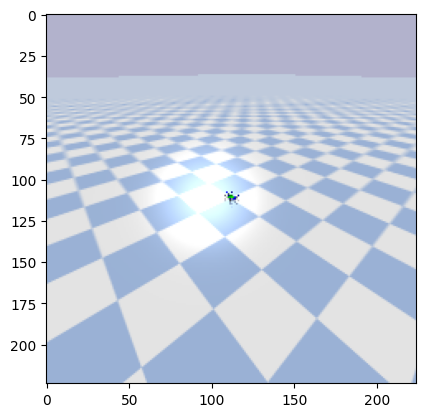

In [4]:
cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
start=np.array(cubePos[0:3])
for i in range(10):
    #clear_output()
    r,f=robot.step(np.zeros_like(robot.action_space)+1)
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
end=np.array(cubePos[0:3])
d=np.sqrt(np.sum(end-start)**2)
print(d)
plt.imshow(robot.getImage())


In [5]:
def moveX(a,vals=[1,-1,1,-1,1,-1]):
    j=1
    for j,i in enumerate(range(0,len(a),3)):
        a[i+1]=vals[j]
        a[i+2]=vals[j]
    return a
def moveY(a,vals=[1,1,1,1,1,1]):
    for i,j in enumerate(range(0,len(a),3)):
        a[j]=vals[i]
    return a

# Agent

In [6]:
class Agent:
    def __init__(self,num_of_motors,size_per_network):
        self.Legs=[]
        self.sensors=[]
        self.cons=[]
        self.weights_idx=[]
        self.num_motors=num_of_motors
        self.size=size_per_network
        id=0
        for i in range(num_of_motors): #create all networks
            self.Legs.append(CTRNN(size_per_network))
            self.weights_idx.append(id)
            id+=(self.Legs[i].weight.flatten().shape[0]+self.Legs[i].bias.flatten().shape[0])
        self.senso_idx=[]
        self.connections=[]
        self.senso_idx_ex=[]
        self.connections_ex=[]
        pred_val=(size_per_network)*num_of_motors
        damp=(self.Legs[i].weight.flatten().shape[0]+self.Legs[i].bias.flatten().shape[0])*(num_of_motors-1)
        for i in range(num_of_motors): #count sensors and interconnections
            self.senso_idx.append(id+size_per_network)
            self.connections.append(id+pred_val+size_per_network)
            self.senso_idx_ex.append(id+size_per_network-damp)
            self.connections_ex.append(id+pred_val+size_per_network-damp)
            id+=size_per_network
        #genes are the number of weights and biases for each network + connections to every node in each network to the leg sensor + connections of inner motors + connection of side motors
        self.num_of_genes=(self.Legs[0].weight.flatten().shape[0]+self.Legs[0].bias.flatten().shape[0])*num_of_motors + size_per_network*num_of_motors + size_per_network*num_of_motors + (num_of_motors//2)*size_per_network
        self.num_of_exlusive_genes=(self.Legs[0].weight.flatten().shape[0]+self.Legs[0].bias.flatten().shape[0]) + size_per_network*num_of_motors + (size_per_network + (num_of_motors//2))*size_per_network
    def set_geno(self,genes):
        if genes.shape[0]==self.num_of_genes: #if all netwrok to be evolved
            for i in range(self.num_motors-1): #get each weight and bias and add it to the network
                w=genes[self.weights_idx[0]:self.weights_idx[0]+self.size]
                b=genes[self.size+self.weights_idx[0]:self.weights_idx[i+1]]
                self.Legs[i].set_parameters(1,b,w)
            w=genes[self.weights_idx[-1]:self.weights_idx[-1]+self.size]
            b=genes[self.size+self.weights_idx[-1]:self.senso_idx[0]]
            self.Legs[-1].set_parameters(1,b,w)
            #TODO this doesnt work yet!
        elif genes.shape[0]==self.num_of_exlusive_genes: #if each network is treated the same (BETTER)
            idx0=self.weights_idx[0] #start from
            idx1=self.weights_idx[1] #end weights
            for i in range(self.num_motors):
                w=genes[idx0:self.size**2]
                b=genes[self.size**2:idx1]
                self.Legs[i].set_parameters(1,b,w)
            assert np.sum(self.Legs[0].weight) == np.sum(self.Legs[-1].weight), "Networks are not the same"
            idx2=self.senso_idx_ex[0]-(self.senso_idx_ex[1]-self.senso_idx_ex[0]) #start from
            self.sensors=np.zeros((self.num_motors,self.size))
            temp=self.senso_idx_ex.copy()
            temp.append(self.connections_ex[0])
            for i in range(self.num_motors-1): #add sensor connections
                idx1=temp[i]
                idx2=temp[i+1]
                genes=genotype[idx1:idx2]
                self.sensors[i]=genes
            #genes=genotype[idx3:self.connections_ex[0]]
            temp=self.senso_idx_ex.copy()
            temp.append(self.connections_ex[0])
            #self.cons=np.zeros((self.num_motors,3,self.cons))
            self.cons=genotype[self.senso_idx_ex[-1]:].reshape((self.num_motors//2 +self.num_motors,self.size)) #self.connections_ex[0]+self.num_motors//2 *
            
    def forward(self,x):
        data=np.dot(x,self.sensors)
        outputs=np.zeros((self.num_motors,self.size))
        for i in range(self.num_motors): #gather outputs
            x=data[i]
            outputs[i]=self.Legs[i].step(x) #ruhn through each network
        SIDES=self.num_motors//2
        con_out=outputs.copy()
        #OPPOSITES
        for i in range(SIDES):
            g=self.cons[i]
            con_out[i]=outputs[SIDES+i]*g
            con_out[SIDES+i]=outputs[i]*g
            c=i+1
        #vertical
        for i in range(1,SIDES-1):
            g=self.cons[c]
            con_out[i]=outputs[SIDES+i]*g
            con_out[SIDES+i]=outputs[i]*g
            c=i+1
        #front and back
        con_out[0]=outputs[SIDES-1]*self.cons[c] #front to back
        con_out[SIDES-1]=outputs[0]*self.cons[c+1] #back to front
        con_out[SIDES]=outputs[-1]*self.cons[c+2] #front to back
        con_out[-1]=outputs[SIDES]*self.cons[c+3] #back to front
        #validation
        con_out[con_out<0]*=0
        con_out[con_out>0]*=1
        outputs=con_out.copy()
        return outputs
class CTRNN:
    def __init__(self, size):
        self.size = size
        self.time_constant = np.ones(size)
        self.bias = np.zeros(size)
        self.activation = np.zeros(size)
        self.output = np.zeros(size)
        self.weight = np.zeros((size, size))
        self.cons=np.zeros((3, size))
        
    def set_parameters(self, time_constant, bias, weight):
        self.time_constant = time_constant
        self.bias = bias
        self.weight = weight.reshape((self.size,self.size))
    
    def set_cons(self,vals):
        self.cons=vals.reshape((3, self.size))

    def step(self, input, step_size=0.01):
        net_input = np.dot(self.weight, self.activation) + self.bias + input
        dx_dt = (1/self.time_constant) * (-self.activation + net_input)
        self.activation += step_size * dx_dt
        self.output = np.tanh(self.activation)
        return self.output

a=Agent(6,6)
print(a.weights_idx)
print(a.senso_idx,a.senso_idx_ex)
print(a.connections,a.connections_ex)
print(a.num_of_genes,a.num_of_exlusive_genes)
genotype=np.random.normal(0,5,(a.num_of_exlusive_genes,))
a.set_geno(genotype)
for i in range(10):
    #clear_output()
    out=a.forward(np.random.random_integers(0,20,(6)))

motor_out=np.concatenate(([out[:,0]],[out[:,1]])).T
print(np.argmax(motor_out,axis=1)) #get horizontal and vertical motor commands


[0, 42, 84, 126, 168, 210]
[258, 264, 270, 276, 282, 288] [48, 54, 60, 66, 72, 78]
[294, 300, 306, 312, 318, 324] [84, 90, 96, 102, 108, 114]
342 132
[0 0 0 0 0 0]


C:\Users\dexte\AppData\Local\Temp\ipykernel_42728\1227331009.py:126: DeprecationWarning: This function is deprecated. Please call randint(0, 20 + 1) instead
  out=a.forward(np.random.random_integers(0,20,(6)))


In [7]:
horizontal=out[:,0]
vertical=out[:,1]
print(horizontal,vertical)

[ 5.17496535  4.36734326  6.1921646  -0.         -0.          2.74387269] [-0. -0. -0. -0. -0. -0.]


# Genetic algorithm

In [8]:
def mutate(geno):
    geno+=np.random.normal(0,3,(geno.shape))
    geno[geno>12]=12
    geno[geno<-12]=-12
    return 

def gen_genotype(shape): #generate a genotype of 1 and 0
    return np.random.normal(0,5,(shape))

def gen_pop(size,pergeno):
    return gen_genotype(size*pergeno).reshape((size,pergeno))
def fitness(robot,start):
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    start=np.array(start)
    cubePos=np.array(cubePos)
    orient=(np.array(cubeOrn)*10).astype(int)[0:3] #x y and z tilt
    max_tilt=np.sum(np.abs(orient))
    return max((np.linalg.norm(start[0:2]-cubePos[0:2])*0.6)-(max_tilt/10+cubePos[-1])*0.4,0)#max distance of x and y
def getFallen():
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    if cubePos[-1]<0: return True
    return False
def runTrial(agent,robot,T):
    dt=0.02
    robot.reset()
    done=False
    a=np.zeros_like(robot.action_space) #first step don't move
    cum_r=0
    t=0
    fl=-1
    fx=0
    start, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    while t<T and not done:
        r,c=robot.step(a)
        f=c[:,1] #get forces
        m=np.sum(a.reshape(6,3),axis=1)
        out=agent.forward(f)
        
        motor_out=np.concatenate(([out[:,0]],[out[:,1]],[out[:,2]])).T
        #motors=np.argmax(motor_out,axis=1) #get horizontal and vertical motor commands
        #temp=motor_out.copy()
        #motor_out*=0
        #motor_out[motors]=temp[motors]
        horizontal=out[:,0]
        vertical=out[:,1]
        a=a*0 #reset
        a=moveX(a,vals=horizontal) #get x motor positions
        a=moveY(a,vals=vertical) #get y motor positions
        cum_r+=r
        f_=fitness(robot,start)
        if f_>fl:
            fx+=f_
        #if cum_r<-10:
        #    done=True
        t+=dt
    #f=fitness(robot,start)
    return fx/(T/dt)

def run(agent,robot,population,generations=500,T=2):
    pop_size=len(population)
    shape=population.shape[1]
    fitness_matrix=np.zeros((pop_size))
    overTime=np.zeros((generations,))
    gen=0
    try:
        while gen < (generations) and overTime[max(gen-1,0)]<1:
            clear_output()
            print("Generation:",gen,"Fitness",overTime[max(gen-1,0)])
            #get mask to select genotypes for battle
            mask=np.random.choice([0, 1], size=pop_size)
            inds=(mask==1).nonzero()[0]
            while len(inds)%2!=0:
                mask=np.random.choice([0, 1], size=pop_size)
                inds=(mask==1).nonzero()[0]
            #get indicies and tournament modes
            inds=inds.reshape(len(inds)//2,2).astype(int)
            fitnesses=np.zeros((len(inds)//2)).astype(int)
            new_inds=np.zeros((len(inds)//2,2)).astype(int)
            #run each trial
            for i in range(len(inds)//2):
                #select genotypes
                g1=population[inds[i][0]]
                g2=population[inds[i][1]]
                #tournament
                agent.set_geno(g1)
                f1=0
                for j in range(3):
                    f1+=runTrial(agent,robot,T)
                f1/=3
                agent.set_geno(g1)
                f2=0
                for j in range(3):
                    f2+=runTrial(agent,robot,T)
                f2/=3
                fitness_matrix[inds[i][0]]=f1
                fitness_matrix[inds[i][1]]=f2
                if f1>f2:
                    fitnesses[i]=f1
                    new_inds[i]=[0,i]
                elif f2>f1:
                    fitnesses[i]=f2
                    new_inds[i]=[1,i]
                else:
                    fitnesses[i]=0
                    new_inds[i]=[0,i]
                print(np.max(fitness_matrix))
                if getFallen():
                    clear_output()
            if getFallen():
                clear_output()
                np.save("model_hex",population)
                print("THE SIMULATION BROKE")
                break
            #get top values and redistribute into the array
            winners=int(len(inds)//2 *0.4)
            mutants=int(len(inds)//2 *0.4)
            other=len(inds)//2 -winners - mutants
            order=np.argsort(fitnesses)
            for i in reversed(range(len(inds)//2)): #loop through backwards leaving the winners in place
                genoWin=new_inds[i][0]
                old_index=new_inds[i][1]
                if i<(len(inds)//2)-winners and i>(len(inds)//2)-winners-mutants: #pick mutants
                    population[inds[old_index][1-genoWin]]=mutate(DC(population[inds[old_index][genoWin]])) #mutate copy
                elif i<(len(inds)//2)-winners-mutants: #the other
                    population[inds[old_index][1-genoWin]]=gen_genotype(shape=shape) #create new genotype
            overTime[gen]=np.max(fitness_matrix)
            gen+=1
    except KeyboardInterrupt:
        np.save("model_hex",population)
    return overTime

## create agent and genes

In [9]:
agent=Agent(6,6)
population=gen_pop(25,agent.num_of_exlusive_genes) #create population
try: population=np.load("model_hex") #if exists
except: pass

genotype=np.random.normal(0,5,(agent.num_of_exlusive_genes,))
agent.set_geno(population[0])
run(agent,robot,population,generations=500,T=2)

THE SIMULATION BROKE


array([0.01009077, 0.01159035, 0.02483468, 0.02483468, 0.02483468,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     